In [1]:
import plotly.graph_objs as go
import pandas as pd
from matchms.importing import load_from_msp
from matchms.logging_functions import set_matchms_logger_level

from utils import is_spectrum_for_compound, append_classes, load_spectra_metadata, normalize_df
from plotting import scatterplot_matplotlib

set_matchms_logger_level('ERROR')

In [2]:
matchms_scores = pd.read_csv("../data/output_matching/matchms/matchms_tol_0.01_1%I_all_peaks_with_0s.tsv", sep="\t")
matchms_scores = matchms_scores[matchms_scores.apply(lambda x: is_spectrum_for_compound(x['query'], x['reference']), axis=1)]

_ , spectra_metadata, _ = load_spectra_metadata("../data/filtered/simulated_matchms_filter_1%I_all_peaks.msp", 'query')
_ , reference_spectra_metadata, _ = load_spectra_metadata("../data/experimental/RECETOX_GC-EI_MS_20201028.msp", 'reference')

In [3]:
merged = matchms_scores.merge(spectra_metadata, on="query", how="inner")
merged.rename(columns={'num_peaks': 'n_peaks_query'}, inplace=True)

merged = merged.merge(reference_spectra_metadata, on="reference", how="inner")
merged.rename(columns={'num_peaks': 'n_peaks_reference'}, inplace=True)

In [4]:
numeric_columns = ['CosineHungarian_0.01_0.0_1.0_matches', 'n_peaks_query', 'n_peaks_reference']
merged[numeric_columns] = merged[numeric_columns].apply(pd.to_numeric, errors='coerce')

merged['FractionQuery'] = merged['CosineHungarian_0.01_0.0_1.0_matches'] / merged['n_peaks_query']
merged['FractionReference'] = merged['CosineHungarian_0.01_0.0_1.0_matches'] / merged['n_peaks_reference']

In [5]:
merged = append_classes(merged, "query")

In [6]:
# Create a scatter plot
def scatterplot_plotly(df, title):
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df['CosineHungarian_0.01_0.0_1.0_scores'],
        y=df['CosineHungarian_0.01_0.0_1.0_matches'],
        mode='markers+text',
        marker=dict(
            size=(df['FractionQuery'] * 20) + 2,  # Adjust the size scaling factor as needed
            color=df['FractionReference'],
            colorscale='Viridis',  # change the colorscale as needed
            colorbar=dict(title='Reference Matched %'),
            cmin=0,  # Set the minimum color limit
            cmax=1,  # Set the maximum color limit
            opacity=0.5
        ),
        text=df['reference'],
        textposition='middle right',
        # textposition=['top right' if i % 2 == 0 else 'bottom right' for i in range(len(df))],  # Make text positions alternating
        name='Matched Ions'
    ))
    fig.update_layout(
        xaxis_title='Score',
        yaxis_title='Matches',
        title_text=title,
        xaxis=dict(range=[0, 1]),  # Set the x-axis limits
        # yaxis=dict(
        #     range=[0, 70],
        #     type='linear',
        # ),
        width=800,
        height=600
    )
    fig.show()
    return fig

In [10]:
# Create a scatter plot
def scatterplot_plotly_with_legends(df, title):
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df['CosineHungarian_0.01_0.0_1.0_scores'],
        y=df['CosineHungarian_0.01_0.0_1.0_matches'],
        mode='markers+text',
        marker=dict(
            size=(df['FractionQuery'] * 20) + 2,  # Adjust the size scaling factor as needed
            color=df['FractionReference'],
            colorscale='Viridis',  # change the colorscale as needed
            colorbar=dict(title='Reference Matched %'),
            cmin=0,  # Set the minimum color limit
            cmax=1,  # Set the maximum color limit
            opacity=0.5
        ),
        text=df['reference'],
        textposition='middle right',
        # textposition=['top right' if i % 2 == 0 else 'bottom right' for i in range(len(df))],  # Make text positions alternating
        name='Matched Ions'
    ))
    fig.add_trace(go.Scatter(
        x=[None],
        y=[None],
        mode='markers',
        marker=dict(size=10, color='black'),
        showlegend=True,
        name='Size represents FractionQuery',
    ))
    fig.update_layout(
        xaxis_title='Score',
        yaxis_title='Matches',
        title_text=title,
        xaxis=dict(range=[0, 1]),  # Set the x-axis limits
        # yaxis=dict(
        #     range=[0, 70],
        #     type='linear',
        # ),
        width=800,
        height=600
    )
    fig.show()
    return fig

In [11]:
grouped_df = merged.groupby('superclass')
for group in grouped_df.groups:
    subset = grouped_df.get_group(group)
    if subset.shape[0] > 10:
        scatterplot_plotly_with_legends(grouped_df.get_group(group), group).write_image(f"scatterplot_{group}.png")

In [8]:
azoles = merged[merged['class'] == 'Azoles']
scatterplot_plotly(azoles, None).write_image(f"scatterplot_azoles.png")

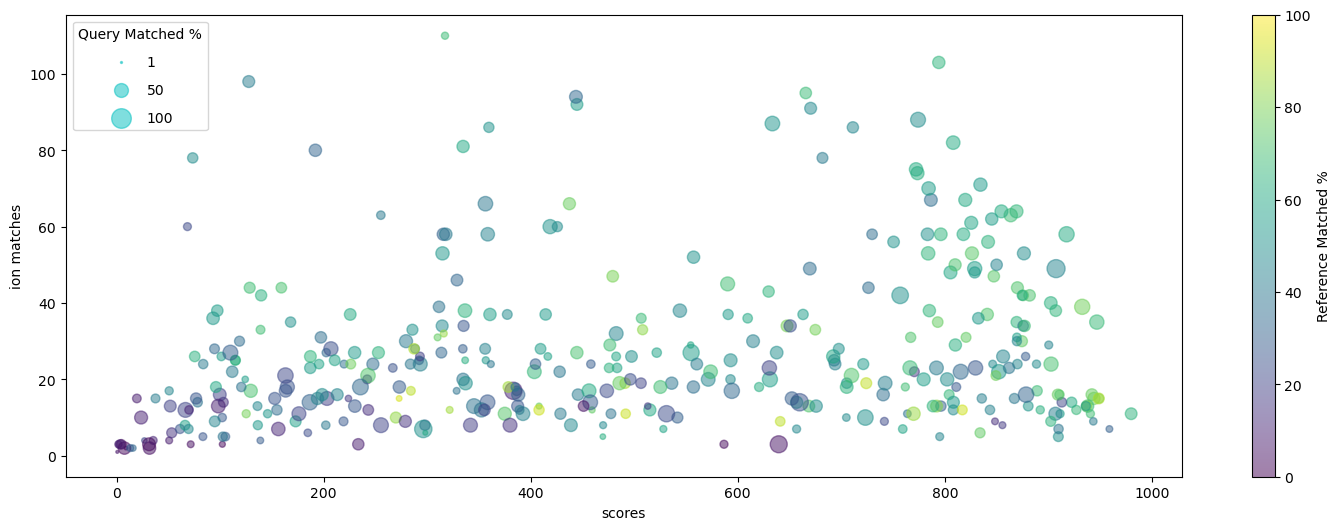

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Create a scatter plot
fig = scatterplot_matplotlib(normalize_df(merged, matches_norm_col=None))
fig.savefig("scatterplot_all.png")